In [7]:
library("ggplot2")
library("dplyr")
library("tidyr")
library(MMWRweek)
library(quantreg)
library("lubridate")


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [43]:
# Read data from 2020-2021
us_death = read.csv(file="../data//Provisional_COVID-19_Death_Counts_by_Week_Ending_Date_and_State.csv")
us_death$Week.Ending.Date = mdy(us_death$Week.Ending.Date)
us_death = us_death[us_death$State == "United States", ]
us_death = us_death[year(us_death$Week.Ending.Date) < 2022, ]
us_death = us_death[!is.na(us_death$Total.Deaths) & !is.na(us_death$Week.Ending.Date), ]
head(us_death)

,Data.as.of,Start.Date,End.Date,Group,Year,Month,MMWR.Week,Week.Ending.Date,State,COVID.19.Deaths,Total.Deaths,Percent.of.Expected.Deaths,Pneumonia.Deaths,Pneumonia.and.COVID.19.Deaths,Influenza.Deaths,Pneumonia..Influenza..or.COVID.19.Deaths,Footnote
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<date>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,01/27/2022,12/29/2019,01/04/2020,By Week,2019/2020,NA,1,2020-01-04,United States,0,60173,98,4111,0,434,4545,
2,01/27/2022,01/05/2020,01/11/2020,By Week,2020,NA,2,2020-01-11,United States,1,60732,97,4153,1,475,4628,
3,01/27/2022,01/12/2020,01/18/2020,By Week,2020,NA,3,2020-01-18,United States,2,59359,98,4066,2,468,4534,
4,01/27/2022,01/19/2020,01/25/2020,By Week,2020,NA,4,2020-01-25,United States,2,59158,99,3915,0,500,4417,
5,01/27/2022,01/26/2020,02/01/2020,By Week,2020,NA,5,2020-02-01,United States,0,58826,99,3818,0,481,4299,
6,01/27/2022,02/02/2020,02/08/2020,By Week,2020,NA,6,2020-02-08,United States,3,59478,100,3823,1,521,4346,


In [59]:
# Read data from 2014-2019
us_death_old = read.csv("../data/Weekly_Counts_of_Deaths_by_State_and_Select_Causes__2014-2019.csv")
us_death_old$Week.Ending.Date = mdy(us_death_old$Week.Ending.Date)
us_death_old = us_death_old[us_death_old$Jurisdiction.of.Occurrence == "United States", ]
us_death_old = us_death_old[!is.na(us_death_old$All..Cause) & !is.na(us_death_old$Week.Ending.Date), ]
head(us_death_old)

,Jurisdiction.of.Occurrence,MMWR.Year,MMWR.Week,Week.Ending.Date,All..Cause,Natural.Cause,Septicemia..A40.A41.,Malignant.neoplasms..C00.C97.,Diabetes.mellitus..E10.E14.,Alzheimer.disease..G30.,⋯,flag_neopl,flag_diab,flag_alz,flag_inflpn,flag_clrd,flag_otherresp,flag_nephr,flag_otherunk,flag_hd,flag_stroke
,<chr>,<int>,<int>,<date>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,United States,2014,1,2014-01-04,54065,50189,882,11244,1654,1780,⋯,,,,,,,,,,
2,United States,2014,2,2014-01-11,56353,52450,905,11504,1735,1917,⋯,,,,,,,,,,
3,United States,2014,3,2014-01-18,54769,51043,919,11496,1660,1914,⋯,,,,,,,,,,
4,United States,2014,4,2014-01-25,54223,50560,845,11629,1602,1862,⋯,,,,,,,,,,
5,United States,2014,5,2014-02-01,54074,50402,890,11584,1586,1867,⋯,,,,,,,,,,
6,United States,2014,6,2014-02-08,53484,49790,849,11355,1643,1873,⋯,,,,,,,,,,


In [117]:
# Combine both data sets
us_death_old$Total.Deaths = us_death_old$All..Cause
us_death_old$data_set = "2014-2019"
us_death$data_set = "2020-2021"
us_death_all = rbind(us_death_old[,c("Week.Ending.Date", "Total.Deaths", "data_set", "MMWR.Week")], 
                                  us_death[,c("Week.Ending.Date", "Total.Deaths", "data_set", "MMWR.Week")])
head(us_death_all)

,Week.Ending.Date,Total.Deaths,data_set,MMWR.Week
,<date>,<int>,<chr>,<int>
1,2014-01-04,54065,2014-2019,1
2,2014-01-11,56353,2014-2019,2
3,2014-01-18,54769,2014-2019,3
4,2014-01-25,54223,2014-2019,4
5,2014-02-01,54074,2014-2019,5
6,2014-02-08,53484,2014-2019,6


Smoothing formula not specified. Using: y ~ x



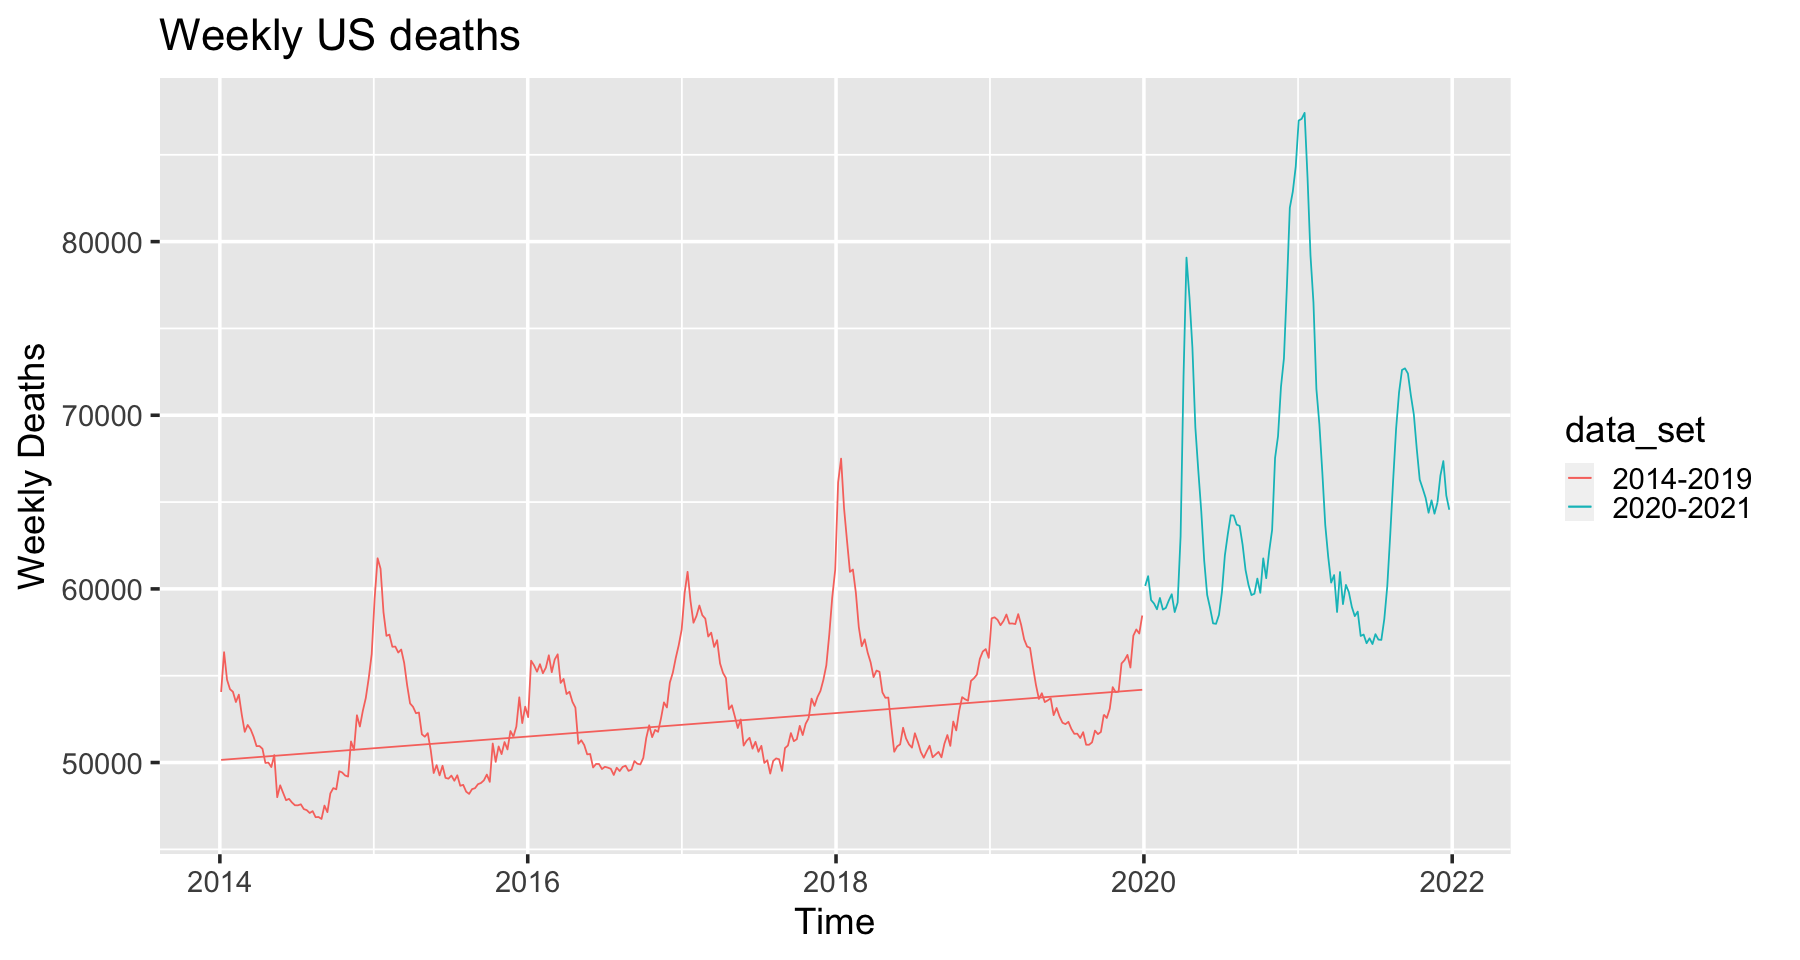

In [119]:
# Plot with quantile trend from 2014-2019
options(repr.plot.width=15, repr.plot.height=8)
b = ggplot(us_death_all, aes(x=Week.Ending.Date, y=Total.Deaths, color=data_set))
b + geom_line() + 
theme_gray(base_size = 22) + 
labs(x = "Time", y = "Weekly Deaths", title="Weekly US deaths") +
geom_quantile(aes(), data=us_death_all[us_death_all$data_set=="2014-2019",], quantiles=c(0.5))

In [125]:
# Fit a trend of 50th quantile from 2014-2019
us_death_all$days = us_death_all$Week.Ending.Date - us_death_all$Week.Ending.Date[1]
rq.fit = rq(Total.Deaths ~ days, data=us_death_all[us_death_all$data_set=="2014-2019",])
us_death_all$detrended = as.numeric(us_death_all$Total.Deaths - us_death_all$days * rq.fit$coef[2])
summary(rq.fit)


Call: rq(formula = Total.Deaths ~ days, data = us_death_all[us_death_all$data_set == 
    "2014-2019", ])

tau: [1] 0.5

Coefficients:
            coefficients lower bd    upper bd   
(Intercept) 50152.60618  49198.72702 50818.35385
days            1.84887      1.31292     2.56260

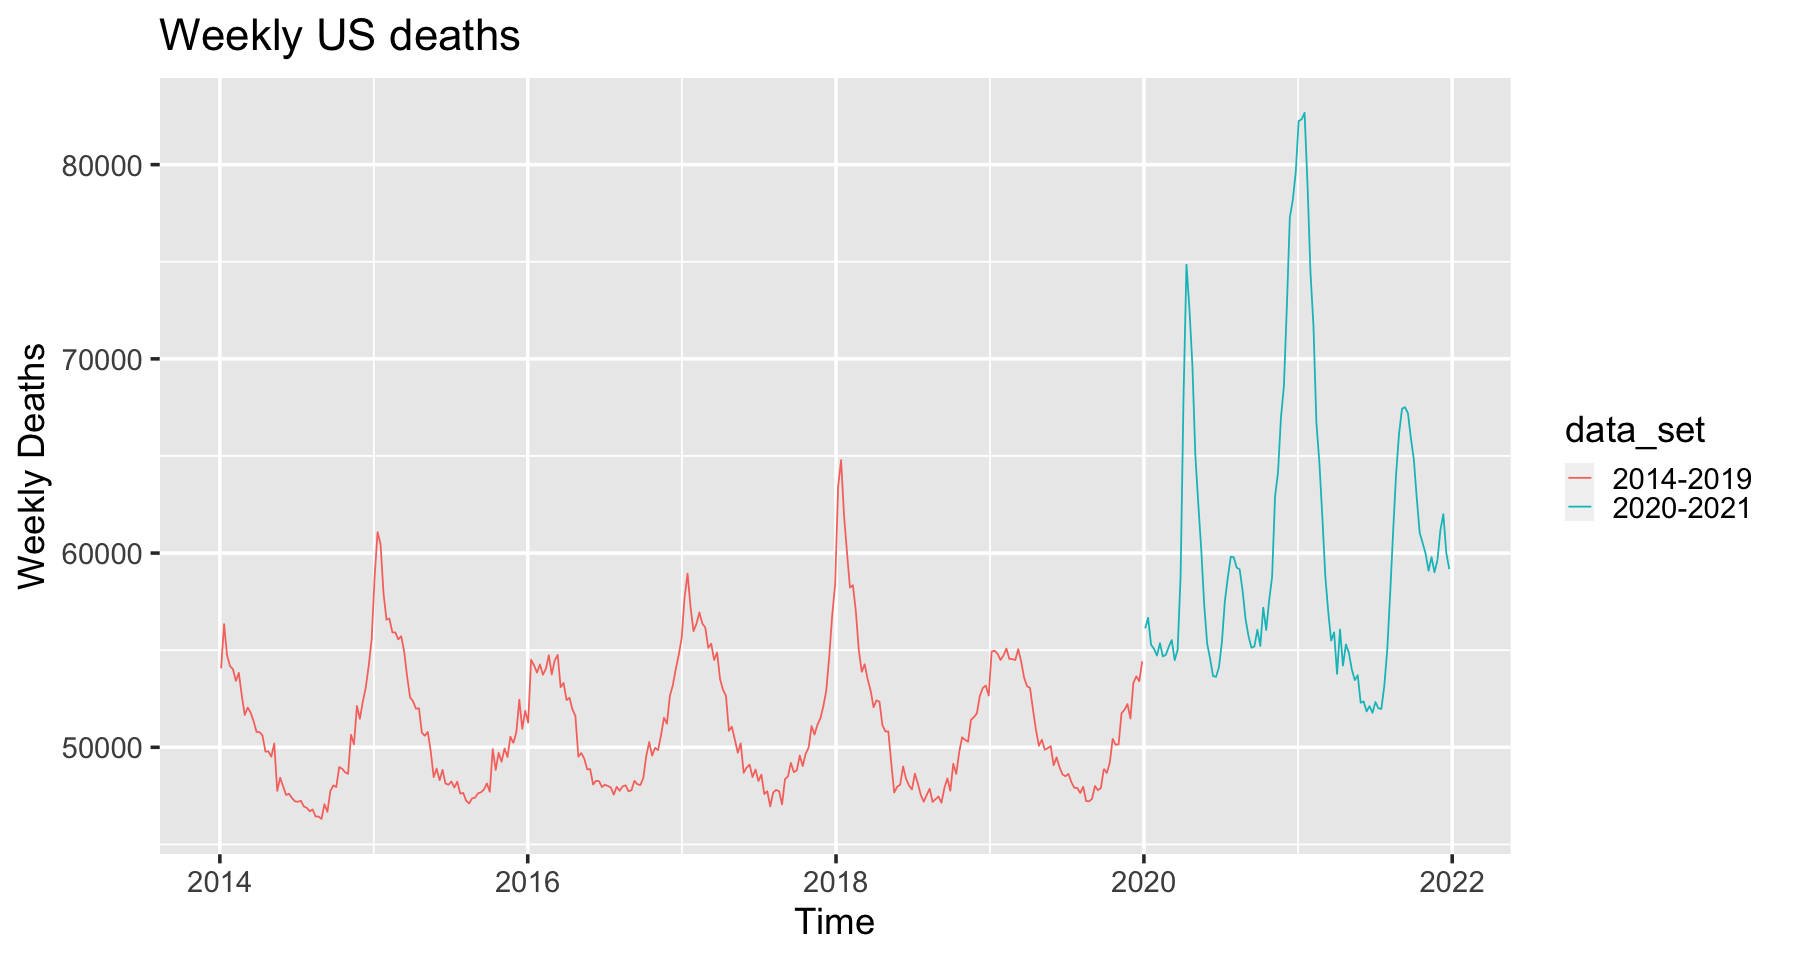

In [133]:
# plot detrended deaths
options(repr.plot.width=15, repr.plot.height=8)
b = ggplot(us_death_all, aes(x=Week.Ending.Date, y=detrended, color=data_set))
b + geom_line() + 
theme_gray(base_size = 22) + 
labs(x = "Time", y = "Weekly Deaths", title="Weekly US deaths")

In [127]:
head(us_death_all)

,Week.Ending.Date,Total.Deaths,data_set,MMWR.Week,days,detrended
,<date>,<int>,<chr>,<int>,<drtn>,<dbl>
1,2014-01-04,54065,2014-2019,1,0 days,54065.00
2,2014-01-11,56353,2014-2019,2,7 days,56340.06
3,2014-01-18,54769,2014-2019,3,14 days,54743.12
4,2014-01-25,54223,2014-2019,4,21 days,54184.17
5,2014-02-01,54074,2014-2019,5,28 days,54022.23
6,2014-02-08,53484,2014-2019,6,35 days,53419.29


In [140]:
# Subtract weekly median from 2014-2019
median = us_death_all[us_death_all$data_set=="2014-2019",] %>% group_by(MMWR.Week) %>% summarise(med = median(detrended))
merged = merge(us_death_all, median, by="MMWR.Week")
head(merged)
merged$centered = merged$detrended - merged$med

,MMWR.Week,Week.Ending.Date,Total.Deaths,data_set,days,detrended,med
,<int>,<date>,<int>,<chr>,<drtn>,<dbl>,<dbl>
1,1,2014-01-04,54065,2014-2019,0 days,54065.00,56329.6
2,1,2020-01-04,60173,2020-2021,2191 days,56122.13,56329.6
3,1,2019-01-05,58305,2014-2019,1827 days,54927.12,56329.6
4,1,2021-01-09,87069,2020-2021,2562 days,82332.20,56329.6
5,1,2018-01-06,66142,2014-2019,1463 days,63437.10,56329.6
6,1,2015-01-10,61763,2014-2019,371 days,61077.07,56329.6


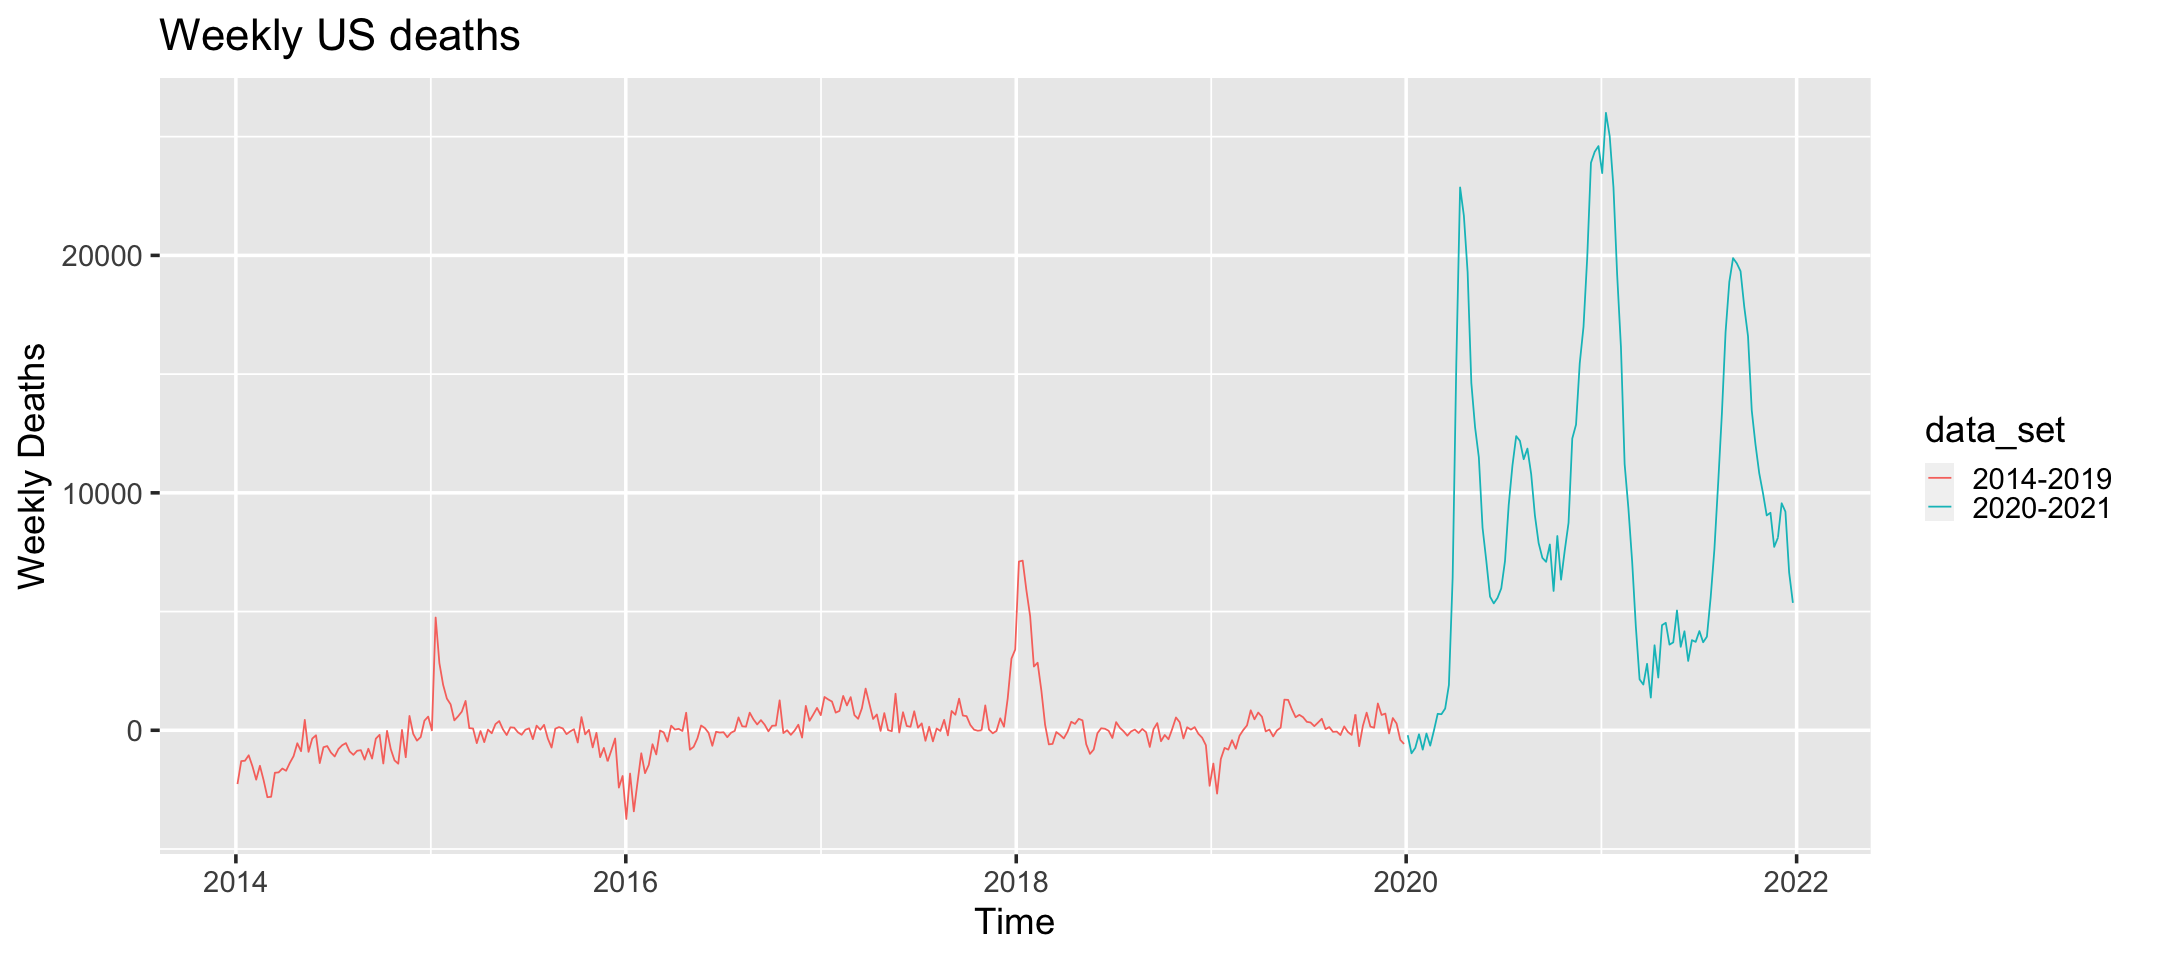

In [141]:
# plot centered deaths
options(repr.plot.width=18, repr.plot.height=8)
b = ggplot(merged, aes(x=Week.Ending.Date, y=centered, color=data_set))
b + geom_line() + 
theme_gray(base_size = 22) + 
labs(x = "Time", y = "Weekly Deaths", title="Weekly US deaths")

In [144]:
# Normalize deaths
merged$normalized = (merged$centered - min(merged$centered)) / (max(merged$centered) - min(merged$centered))

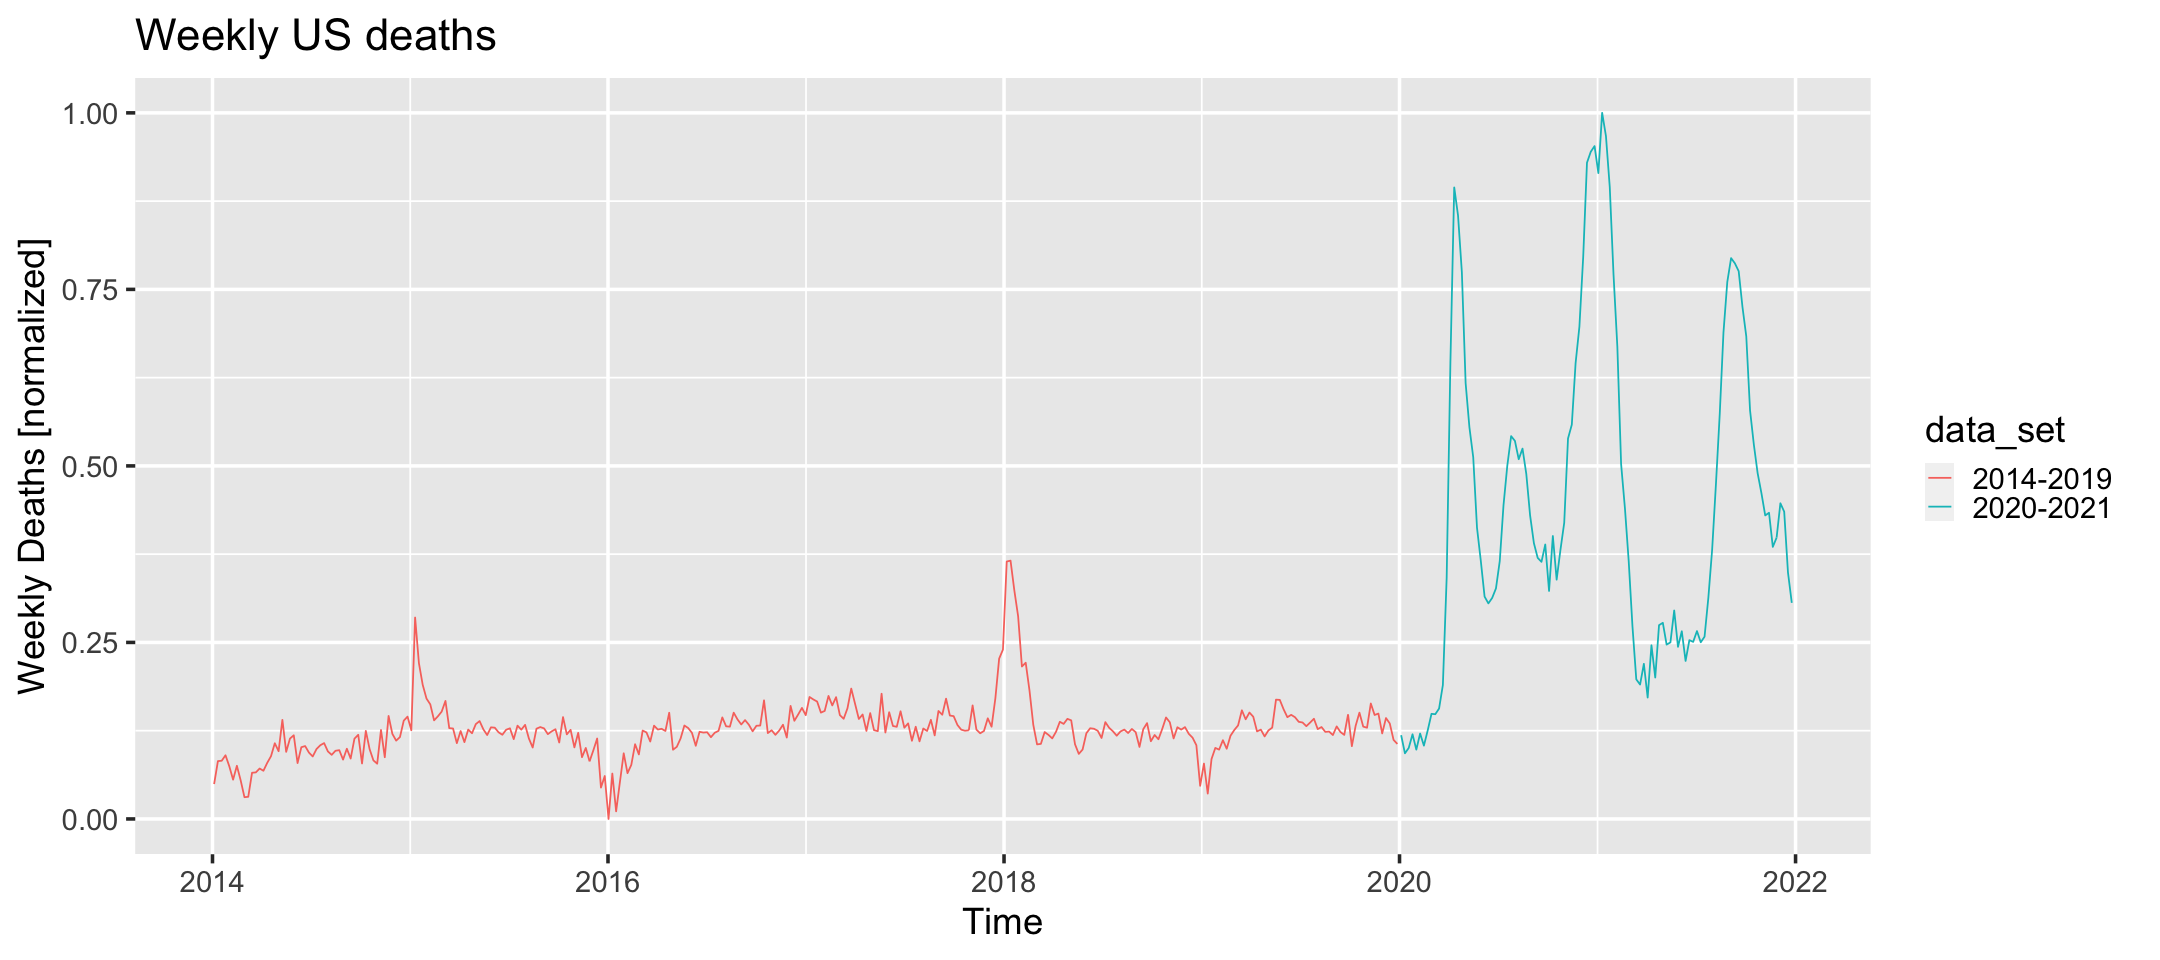

In [145]:
# plot centered deaths
b = ggplot(merged, aes(x=Week.Ending.Date, y=normalized, color=data_set))
b + geom_line() + 
theme_gray(base_size = 22) + 
labs(x = "Time", y = "Weekly Deaths [normalized]", title="Weekly US deaths")